## DDPG Main

### Data Preprocessing

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data
#C:\Users\rohit\OneDrive\Documents\Asset-Pricing-with-Reinforcement-Learning\XOM_30_minute_6_month_data.csv
df = pd.read_csv('XOM_30_minute_6_month_data.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)

# Normalize
scaler = MinMaxScaler()
df[['Last Price', 'Volume', 'SMAVG (15)']] = scaler.fit_transform(df[['Last Price', 'Volume', 'SMAVG (15)']])

# Split into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

In [3]:
print(train_df[10:])

                    Date  Last Price    Volume  SMAVG (15)
2331 2023-03-07 20:00:00    0.596608  0.049707    0.072420
2330 2023-03-07 20:30:00    0.606681  0.165330    0.086878
2329 2023-03-08 14:30:00    0.634154  0.134774    0.099523
2328 2023-03-08 15:00:00    0.608055  0.086473    0.077523
2327 2023-03-08 15:30:00    0.571654  0.099766    0.067301
...                  ...         ...       ...         ...
473  2023-09-29 20:30:00    0.881409  0.306496    0.180971
472  2023-10-02 14:30:00    0.794870  0.171930    0.194260
471  2023-10-02 15:00:00    0.755034  0.144825    0.184963
470  2023-10-02 15:30:00    0.762818  0.113712    0.166506
469  2023-10-02 16:00:00    0.764192  0.092697    0.157100

[1863 rows x 4 columns]


### Environment

In [6]:
import gym
import numpy as np
from gym import spaces
from enum import Enum

# ignore all window size will test
# Define the Trading Environment
class DDPGTradingEnv(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 3}

    def __init__(self, df, window_size, render_mode=None):
        super(DDPGTradingEnv, self).__init__()

        self.df = df
        # Set to 1 for now
        self.window_size = window_size
        # for printing
        self.render_mode = render_mode

        self.prices, self.signal_features = self._process_data()
        
        self.shape = (window_size, self.signal_features.shape[1])
        #self.shape = self.signal_features.shape[0]

        # Discrete action space for "buy," "sell," and "hold"
        discrete_actions = spaces.Discrete(3)
        # Continuous action space for quantity (assumed to be in the range [0, 1])
        continuous_quantity = spaces.Box(low=0, high=1, shape=(1,), dtype=float)
        # Combine the discrete and continuous action spaces using a Tuple
        self.action_space = spaces.Tuple((discrete_actions, continuous_quantity))

        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=float)

        print("Action space")
        print(self.action_space)

        # Initialize an empty list to record profit
        self.profit_history = []
        
        # Initialise trading portfolio
        self.reset()

    # Initialises trading portfolio
    def reset(self):
        # Step is 1
        self.current_step = self.window_size
        self.total_profit = 0
        # Stores profit history
        self.history = []
        # Initial balance
        self.balance = 10000
        # Number of shares
        self.shares_held = 0
        # Total current balance
        self.portfolio_value = self.balance
        # NEED TO MAKE THIS CONTINUOUS. Potentially we can give limits.
        # self.trade_amount = 100
        self.previous_portfolio_value = self.portfolio_value
        # Set initial balance at the start of each episode
        self.initial_balance = self.balance
        return self._get_observation()

    # Stores prices and features (for now just the price)
    def _process_data(self):

        # Extract prices and features
        prices = df['Last Price'].values
        #features = df[['Last Price', 'Volume', 'SMAVG (15)']].values
        features = df[['Last Price']].values

        return prices, features

    def _get_observation(self):
        """
        Returns an observation window containing the signal features for the current step.
        """
        # Ensure the current step does not exceed the bounds of our data
        #assert self.current_step >= self.window_size

        # Get the observation window from the signal features
        start = self.current_step - self.window_size
        end = self.current_step
        observation = self.signal_features[start:end]

        return observation

    def _take_action(self, action_value):
        current_price = self.prices[self.current_step]
        if action_value > 0:
            self._buy_stock(current_price, amount=action_value)
        elif action_value < 0:
            self._sell_stock(current_price, amount=-action_value)


    def _update_portfolio(self, action_value):
        current_price = self.prices[self.current_step]
        if action_value > 0:
            self._buy_stock(current_price, amount=action_value)
        elif action_value < 0:
            self._sell_stock(current_price, amount=-action_value)
        # Update the portfolio value
        self.portfolio_value = self.balance + self.shares_held * current_price
        

    def _buy_stock(self, current_price, amount):
        # Determine the actual amount of stock to buy based on 'amount'
        # For example, you might interpret 'amount' as a percentage of your balance
        buy_amount = min(self.balance / current_price, amount)
        self.balance -= buy_amount * current_price
        self.shares_held += buy_amount

    def _sell_stock(self, current_price, amount):
        # Determine the actual amount of stock to sell based on 'amount'
        # Ensure that you don't sell more than you hold
        sell_amount = min(self.shares_held, amount)
        self.balance += sell_amount * current_price
        self.shares_held -= sell_amount


    """def step(self, action):
        print(f"Received action in step: {action}")
        action_value = action[0]
        # Debugging: print the type and value of action
        print(f"Action type: {type(action)}, Action value: {action}")

        # Assuming action is a float
        action_value = action  # No need for indexing

        # Now pass action_value to _take_action and the rest of the code
        self._take_action(action_value)

        # Advance the current step
        self.current_step += 1

        # Calculate reward
        reward = self._calculate_reward(action)

        # Check if the end of the data is reached
        done = self.current_step >= len(self.prices) - 1

        # Get the next observation
        observation = self._get_observation()

        # Additional information, useful for debugging
        info = {'current_step': self.current_step, 'total_profit': self.total_profit}
        reward = self._calculate_reward(action)
        self.profit_history.append(self.total_profit)  # Record profit
        return observation, reward, done, info"""
    def step(self, action):
        action_value = action.item()  # Extract the single value from the array
        self._take_action(action_value)
        self.current_step += 1
        reward = self._calculate_reward(action_value)
        done = self.current_step >= len(self.prices) - 1
        observation = self._get_observation()
        info = {'current_step': self.current_step, 'total_profit': self.total_profit}
        self.profit_history.append(self.total_profit)  # Record 
        print(f"Step: ",self.current_step,". Portfolio value: ",self.portfolio_value)
        return observation, reward, done, info

    def render(self, mode='human'):
        # Simple text rendering
        if mode == 'human':
            print(f"Step: {self.current_step}, Total Profit: {self.total_profit}")

    def _calculate_reward(self, action):
        """
        Calculate the reward based on the action taken.
        Action can either be buying or selling a stock.
        The reward is the change in portfolio value as a result of the action.
        """
        # Assuming self.portfolio_value stores the current value of the portfolio
        previous_portfolio_value = self.portfolio_value

        # Update portfolio value based on the action
        self._update_portfolio(action)

        # New portfolio value
        current_portfolio_value = self.portfolio_value

        # Reward is the change in portfolio value
        reward = current_portfolio_value - previous_portfolio_value

        self._update_portfolio(action)  # Ensure this method updates the portfolio value
        current_portfolio_value = self.portfolio_value
        reward = current_portfolio_value - self.previous_portfolio_value
        self.previous_portfolio_value = current_portfolio_value
        self._update_profit(action)
        return reward

    def _update_profit(self, action):
        """
        Update the total profit based on the action taken.
        """
        current_price = self.prices[self.current_step]

        # Update the portfolio after the action
        self._update_portfolio(action)

        # Calculate total profit as the difference between current portfolio value and initial balance
        self.total_profit = self.portfolio_value - self.initial_balance
        # Print for debugging
        print(f"Updated total profit: {self.total_profit}")



### Training

In [7]:
import numpy as np
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
window_size=1
# Initialises trading environment (window size set to 1)
env = DDPGTradingEnv(df, window_size)

# Add some noise for exploration
# n_actions = env.action_space.shape[0]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Initialize DDPG model. MlpPolicy refers to the neural network.
# We will have to create this.
ddpg_model = DDPG("MlpPolicy", env, action_noise=None, verbose=1)

# Train the model
# Set the total number of timesteps the length of the training data
ddpg_model.learn(total_timesteps=df.shape[1])




# Reset the environment before running the model

# # Run the model on the entire dataset
# for i in range(total_timesteps):
#     action, _states = ddpg_model.predict(obs, deterministic=True)
#     obs, rewards, done, info = env.step(action)

#     # Optional: Log results
#     print(f"Step: {i}, Reward: {rewards}, Total Profit: {info['total_profit']}")

#     if done:
#         obs = env.reset()


Action space
Tuple(Discrete(3), Box(0.0, 1.0, (1,), float64))
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


AssertionError: The algorithm only supports (<class 'gymnasium.spaces.box.Box'>,) as action spaces but Tuple(Discrete(3), Box(0.0, 1.0, (1,), float64)) was provided

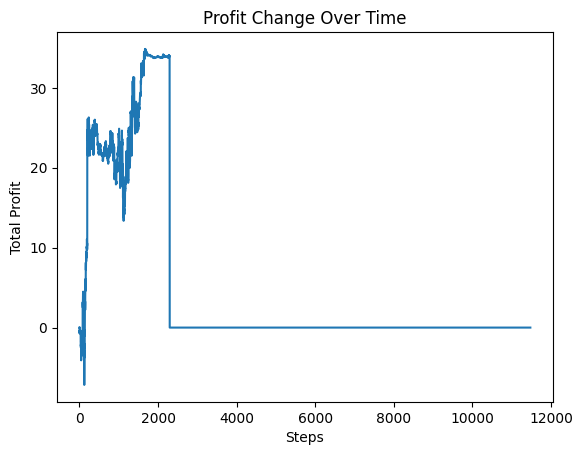

In [130]:
import matplotlib.pyplot as plt

# Plotting the profit change
plt.plot(env.profit_history)
plt.title("Profit Change Over Time")
plt.xlabel("Steps")
plt.ylabel("Total Profit")
plt.show()

In [108]:
# import gym
# import numpy as np
# from gym import spaces
# from stable_baselines3 import DDPG
# from stable_baselines3.common.noise import NormalActionNoise

# # Define your DDPGTradingEnv class here

# # Initialize the environment
# env = DDPGTradingEnv(df, window_size, render_mode=False)

# # Determine the number of actions
# n_actions = env.action_space.shape[-1]

# # Define the action noise
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# # Initialize the DDPG model
# ddpg_model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)

# test_action = np.array([0.5])  # Sample action
# observation, reward, done, info = env.step(test_action)

# # Proceed with training and other operations
# #ddpg_model.learn(total_timesteps=10000)


(1,)
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Updated portfolio. Portfolio value: 9999.99496332384
Updated portfolio. Portfolio value: 9999.99496332384
Updated portfolio. Portfolio value: 9999.994963323838
Updated total profit: -0.005036676162490039


C:\Users\rohit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [131]:
# obs = env.reset()
# for i in range(1000):
#     action, _states = ddpg_model.predict(obs, deterministic=True)
#     obs, rewards, dones, info = env.step(action)
#     env.render()

Updated total profit: 0.0
Step:  61 . Portfolio value:  10000.0
Step: 61, Total Profit: 0.0
Updated total profit: 0.0
Step:  62 . Portfolio value:  10000.0
Step: 62, Total Profit: 0.0
Updated total profit: 0.0
Step:  63 . Portfolio value:  10000.0
Step: 63, Total Profit: 0.0
Updated total profit: 0.0
Step:  64 . Portfolio value:  10000.0
Step: 64, Total Profit: 0.0
Updated total profit: 0.0
Step:  65 . Portfolio value:  10000.0
Step: 65, Total Profit: 0.0
Updated total profit: 0.0
Step:  66 . Portfolio value:  10000.0
Step: 66, Total Profit: 0.0
Updated total profit: 0.0
Step:  67 . Portfolio value:  10000.0
Step: 67, Total Profit: 0.0
Updated total profit: 0.0
Step:  68 . Portfolio value:  10000.0
Step: 68, Total Profit: 0.0
Updated total profit: 0.0
Step:  69 . Portfolio value:  10000.0
Step: 69, Total Profit: 0.0
Updated total profit: 0.0
Step:  70 . Portfolio value:  10000.0
Step: 70, Total Profit: 0.0
Updated total profit: 0.0
Step:  71 . Portfolio value:  10000.0
Step: 71, Total 